This experiment implements a face mask detection system using transfer learning with a pre-trained MobileNetV2 model, employing ImageNet-based preprocessing, data augmentation, and regularization techniques to achieve accurate and well-generalized Mask/No-Mask classification.

Dataset: https://www.kaggle.com/datasets/omkargurav/face-mask-dataset/data

In [2]:
!pip install numpy matplotlib opencv-python scikit-learn tensorflow

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ------ --------------------------------- 1.3/8.1 MB 6.1 MB/s eta 0:00:02
   ------------ --------------------------- 2.6/8.1 MB 6.6 MB/s eta 0:00:01
   -------------------- ------------------- 4.2/8.1 MB 7.2 MB/s eta 0:00:01
   ----------------------------- ---------- 6.0/8.1 MB 7.1 MB/s eta 0:00:01
   ---------------------------------- ----- 7.1/8.1 MB 6.8 MB/s eta 0:00:01
   -------------------------------------- - 7.9/8.1 MB 6.8 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 5.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/39.0 MB ? eta -:--:--
   - -------------------------------------- 1.3/39.0 MB 8.4 MB/s eta 0:00:05
   -- ------------------------------------- 2.9/39.0 MB 8.0 MB/s eta 0:00:05
   ---- ----------------------------------- 3.9/39.0 MB 7.1 MB/s eta 0:00:05
   ----- ---------------------------------- 5.2/39.0 MB 6.9 MB/s eta 0:00:05
   ------ -----------

Step 1: Imports & Setup

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.mobilenet_v2 import (
    MobileNetV2, preprocess_input
)


c:\Users\MOHAN\anaconda3\envs\pyro\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Step 2: Load & Preprocess Dataset

In [4]:
def load_data(folder_path, target_size=(128, 128)):
    images = []
    labels = []
    
    categories = {'with_mask': 1, 'without_mask': 0}
    
    for category, label in categories.items():
        path = os.path.join(folder_path, category)
        for img_name in os.listdir(path):
            try:
                img = Image.open(os.path.join(path, img_name)).convert('RGB')
                img = img.resize(target_size)
                images.append(np.array(img))
                labels.append(label)
            except:
                continue
                
    return np.array(images), np.array(labels)


In [5]:
# Load data
X, Y = load_data(r"C:\Users\MOHAN\Downloads\face mask detection dataset\data")

# MobileNetV2 preprocessing (IMPORTANT)
X = preprocess_input(X)

# Stratified split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, stratify=Y, random_state=42
)

print("Training samples:", X_train.shape)
print("Testing samples:", X_test.shape)


c:\Users\MOHAN\anaconda3\envs\pyro\Lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training samples: (6042, 128, 128, 3)
Testing samples: (1511, 128, 128, 3)


Step 3: Data Augmentation

In [6]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
])


Step 4: Build Transfer Learning Model

In [7]:
base_model = MobileNetV2(
    input_shape=(128, 128, 3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [8]:
model = keras.Sequential([
    data_augmentation,
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

Step 5: Train the Model

In [13]:
callbacks = [
    keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-4,
    restore_best_weights=True,
    verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        patience=2, factor=0.3
    )
]


In [14]:
history = model.fit(
    X_train, Y_train,
    epochs=15,
    validation_split=0.1,
    callbacks=callbacks,
    batch_size=32
)


Epoch 1/15
170/170 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.9805 - loss: 0.0524 - val_accuracy: 0.9802 - val_loss: 0.0642 - learning_rate: 9.0000e-05
Epoch 2/15
170/170 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.9831 - loss: 0.0467 - val_accuracy: 0.9818 - val_loss: 0.0605 - learning_rate: 9.0000e-05
Epoch 3/15
170/170 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.9822 - loss: 0.0477 - val_accuracy: 0.9802 - val_loss: 0.0577 - learning_rate: 9.0000e-05
Epoch 4/15
170/170 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.9866 - loss: 0.0452 - val_accuracy: 0.9818 - val_loss: 0.0610 - learning_rate: 9.0000e-05
Epoch 5/15
170/170 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.9844 - loss: 0.0449 - val_accuracy: 0.9818 - val_loss: 0.0647 - learning_rate: 9.0000e-05
Epoch 6/15
170/170 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.9844 - loss: 0.0399 - val_accuracy: 0.9818 - val_loss: 0.0601 - learning_rate: 2.7000e-05
Epoch 7/15
170/170 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step

Step 6: Training Visualization

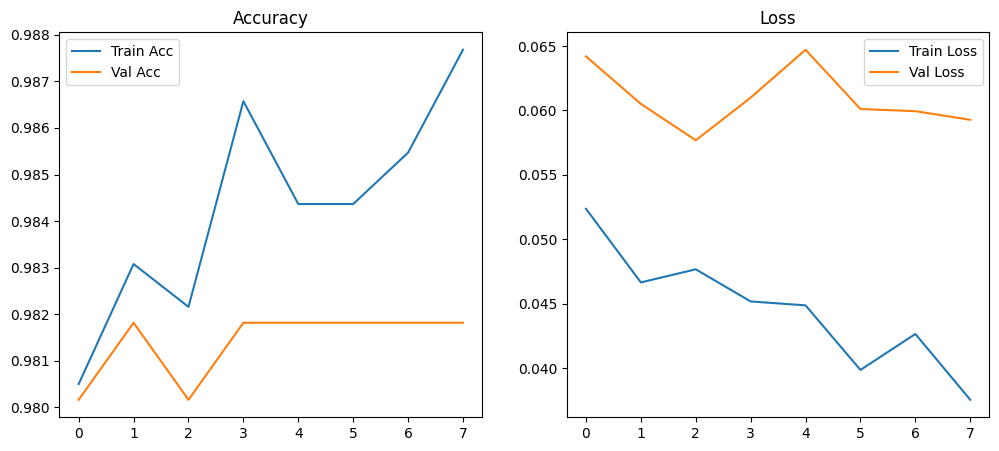

In [15]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")

plt.show()


Step 7: Evaluation & Metrics

In [16]:
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9887 - loss: 0.0303
Test Accuracy: 98.87%


In [17]:
# Detailed evaluation
Y_pred = np.argmax(model.predict(X_test), axis=1)

print(classification_report(
    Y_test, Y_pred,
    target_names=["Without Mask", "With Mask"]
))


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step
              precision    recall  f1-score   support

Without Mask       0.99      0.99      0.99       766
   With Mask       0.99      0.99      0.99       745

    accuracy                           0.99      1511
   macro avg       0.99      0.99      0.99      1511
weighted avg       0.99      0.99      0.99      1511



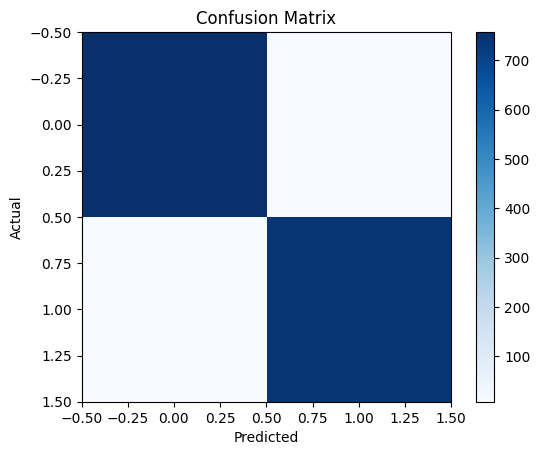

In [18]:
# Confusion Matrix
cm = confusion_matrix(Y_test, Y_pred)
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Step 8: Sample test

In [19]:
labels = ["No Mask", "Mask"]

def predict_mask(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (128, 128))
    img_preprocessed = preprocess_input(img_resized)
    img_reshaped = np.expand_dims(img_preprocessed, axis=0)
    
    prediction = model.predict(img_reshaped)
    label = labels[np.argmax(prediction)]
    
    plt.imshow(img)
    plt.title(f"Prediction: {label}")
    plt.axis('off')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


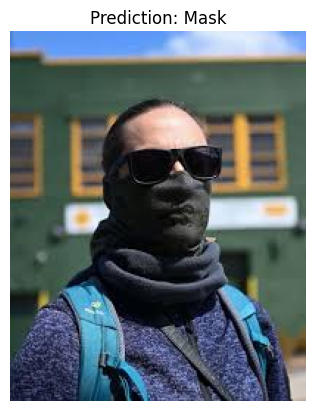

In [21]:
predict_mask(r"C:\Users\MOHAN\Downloads\face mask detection dataset\data\with_mask\with_mask_776.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


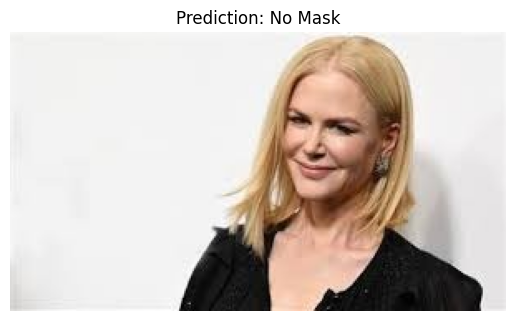

In [22]:
predict_mask(r"C:\Users\MOHAN\Downloads\face mask detection dataset\data\without_mask\without_mask_928.jpg")